# Plot the outcome of potential DCO systems

I define "potential DCO" as systems that form a DCO at any metallicity in my discrete grid of metallicities

In [7]:
import numpy as np
import os 
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import colorsys
from matplotlib.gridspec import GridSpec

import scipy
print(scipy.__version__)

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=SMALL_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


# Turn off natural name warning for panda tables (this is due to '@' and '>' in the COMPAS column names)
import warnings
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)

######################################
# Helper function to make color darker
def darken_color(color, factor=0.8):
    r, g, b = (int(color[i:i+2], 16)/255 for i in (1, 3, 5))
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return '#%02x%02x%02x' % tuple(int(x*255) for x in colorsys.hls_to_rgb(h, l*factor, s))

metallicities = [0.0001, 0.00017321, 0.0003, 0.00054772, 0.001, 0.002, 0.004, 0.00632456, 0.01, 0.01414214, 0.02, 0.03] #np.unique(potential_DCO_progenitors['Metallicity@ZAMS(1)'])
Z_Zsun = np.log10(np.array(metallicities)/0.014)

######################################
home_dir = os.path.expanduser("~") 
Zenodo_data_dir = f'{home_dir}/ceph/CompasOutput/Zenodo_vanSon2024/' # change to your local path
datar_root =  f"{Zenodo_data_dir}/simulations/" #  f"{home_dir}/ceph/CompasOutput/{compas_v}/"# compas_v = "v03.01.02"

sim_name        = 'NewWinds_RemFryer2012'
channel_key     = '' # '', '_stable' '_CE' '_CHE'  


1.13.1


# Get the endpoint of all potential DCO systems at different metallicities

In [8]:
def get_endpoint_numbers(table = None):

    grouped_byZ = table.groupby('Metallicity@ZAMS(1)')

    N_tot_DCO_prog  = grouped_byZ.size()

    N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
    N_mergers       = grouped_byZ['Merger'].apply(lambda x: (x==1).sum())

    # Make sure all the things below are not unbound or mergers
    not_unbound_nor_merger = np.logical_and(table['Unbound'] == 0, table['Merger'] == 0)
    DCO_merger      = (table['Merges_Hubble_Time'] == 1)

    N_BBH           = grouped_byZ.apply(lambda x: (not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() ) 
    N_mergingBBH    = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() ) 

    N_BHNS          = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
                                                        np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 13))).sum())
    N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
                                                        np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 13))).sum())

    N_NSNS          = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )
    N_mergingNSNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )

    N_WD            = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(x['Stellar_Type(1)'].isin([10, 11, 12]), x['Stellar_Type(2)'].isin([10, 11, 12]))).sum())
    N_massless_rem  =  grouped_byZ.apply(lambda x: (not_unbound_nor_merger &np.logical_or(x['Stellar_Type(1)'] == 15, x['Stellar_Type(2)'] == 15)).sum() ) 


    # IDK whats going on here?
    not_unbound         = table['Unbound'] == 0
    not_merger          = table['Merger'] == 0
    not_BBH             = ~np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 14)
    not_NSBH            = ~np.logical_or(np.logical_and(table['Stellar_Type(1)'] == 13, table['Stellar_Type(2)'] == 14),
                                np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 13))
    not_NSNS            = ~np.logical_and(table['Stellar_Type(1)'] == 13, table['Stellar_Type(2)'] == 13)
    not_massless_rem    = ~(np.logical_or(table['Stellar_Type(1)'] == 15, table['Stellar_Type(2)'] == 15))
    not_WD              = ~(np.logical_or(table['Stellar_Type(1)'].isin([10, 11, 12]), table['Stellar_Type(2)'].isin([10, 11, 12])))

    # Check if there are thing that are 'other'
    other_bool = not_unbound* not_merger * not_BBH * not_NSBH * not_NSNS * not_massless_rem * not_WD

    return  N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool



## Load the data


#### Data manipulation
Happens in [ DataManipulation notebook](./DataManipulation.ipynb)

In [9]:
# Load the data dictionary if it exists
if os.path.isfile(Zenodo_data_dir + 'Fig3A_plotdata.pkl'):
    with open(Zenodo_data_dir + 'Fig3A_plotdata.pkl', 'rb') as f:
        results = pickle.load(f)
else:
    ####################################
    # Take the base potential DCO progenitor table
    prog_table_name = f'potential_DCO_progenitors_Allinfo{channel_key}.h5'

    if os.path.isfile(datar_root+ f'/{sim_name}/'+prog_table_name):
        potential_DCO_progenitors = pd.read_hdf(datar_root + f'{sim_name}/' + prog_table_name, key='All_DCO')
        print('Table exists, reading in... ',  potential_DCO_progenitors.info())
    else:
        print(f'error, {datar_root}/{sim_name}/{prog_table_name} does not exist, you should make it using "DataManipulation.ipynb" first')

    potential_DCO_progenitors.reset_index(drop=True, inplace=True) 

    # Split our potential DCO progenitors into BBH, BHNS and NSNS progenitors
    potential_BBH_progenitors  = potential_DCO_progenitors[potential_DCO_progenitors['pot_BHBH_bool']]
    potential_BHNS_progenitors = potential_DCO_progenitors[potential_DCO_progenitors['pot_BHNS_bool']]
    potential_NSNS_progenitors = potential_DCO_progenitors[potential_DCO_progenitors['pot_NSNS_bool']]


    # Preload the data to speed up the plotting 
    # List of panda tables of pot DCO progenitors
    titles = ["All", "BBH", "BHNS", "NSNS"]
    # List of tables of pot DCO progenitors
    dfs = [potential_DCO_progenitors, potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors]

    # Initialize an empty dictionary to store the results
    results = {}

    # Loop over the dataframes and titles
    for df, title in zip(dfs, titles):
        # Get the results from get_endpoint_numbers
        results[title] = get_endpoint_numbers(table = df)

    # Save the dictionary to a file
    with open(Zenodo_data_dir + 'Fig3A_plotdata.pkl', 'wb') as f:
        pickle.dump(results, f)


# Start plotting the endpoints per metallicity, for each DCO flavor

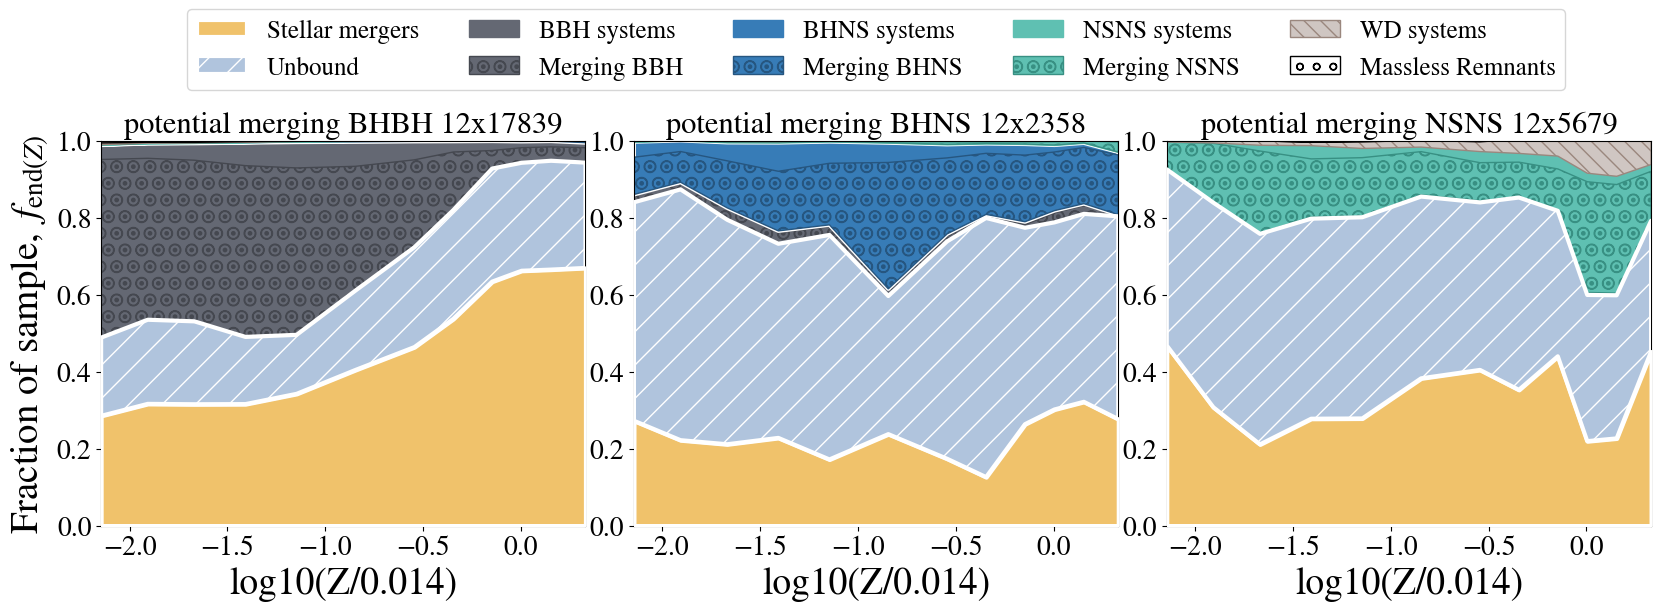

In [10]:
###########################################
# Create a figure
fig = plt.figure(figsize=(20, 5))

# Create a GridSpec with 1 row and 3 columns
gs = GridSpec(1, 3, figure=fig)
axes = [fig.add_subplot(gs[0, i]) for i in range(3)] # Create 3 subplots on a line

# Colors
color_dict = {'BBH': '#646873', 
              'BHNS': '#377CB7',
              'NSNS': '#5FC0B2',
              'WDWD': '#cfc6c2',
              'masslessRemnants': '#000000',
              'StellarMergers': '#F0C26B', 
              'UnboundSystems': '#b0c4dd'}

DCO_flavors = ["BBH", "BHNS", "NSNS"]

# Loop over the axes and DCO flavors
for ax, flavor in zip(axes, DCO_flavors):

    try: 
        N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool = results[flavor] # get_endpoint_numbers(table = df)

        # Normalize or abs numbers?
        norm = N_tot_DCO_prog

        bottom = np.zeros(len(Z_Zsun))

        # stellar mergers
        ax.fill_between(Z_Zsun, bottom/norm, N_mergers/norm, color=color_dict['StellarMergers'], 
                        edgecolor = 'white', lw = 3, label='Stellar mergers', alpha = 1, zorder = 10)
        bottom += N_mergers

        # Unbound systemd
        ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_unbound)/norm, color=color_dict['UnboundSystems'],
                        edgecolor = 'white', lw = 3,  hatch='/', label='Unbound', alpha = 1, zorder = 10)
        bottom += N_unbound

        # BBH systems
        ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_BBH)/norm, color=color_dict['BBH'], label='BBH systems', alpha = 1)
        ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_mergingBBH)/norm, color=color_dict['BBH'], 
                        edgecolor = darken_color(color_dict['BBH'], factor=0.7), hatch='O.', label='Merging BBH', alpha = 1)
        bottom += N_BBH

        # BHNS systems
        ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_BHNS)/norm, color=color_dict['BHNS'], label='BHNS systems', alpha = 1)
        ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_BHNS)/norm, color="none", 
                        edgecolor = 'white', lw = 3, label=None, alpha = 1)
        ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_mergingBHNS)/norm, color=color_dict['BHNS'], 
                        edgecolor = darken_color(color_dict['BHNS'], factor=0.7), hatch='O.', label='Merging BHNS', alpha = 1)
        bottom += N_BHNS

        # NSNS systems
        ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_NSNS)/norm, color=color_dict['NSNS'], label='NSNS systems', alpha = 1)
        ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_mergingNSNS)/norm, color=color_dict['NSNS'], 
                        edgecolor = darken_color(color_dict['NSNS'], factor=0.7), hatch='O.', label='Merging NSNS', alpha = 1)
        bottom += N_NSNS

        # WD systems
        ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_WD)/norm, color=color_dict['WDWD'],
                        edgecolor=darken_color(color_dict['WDWD'], factor=0.7), hatch = '\\\\', label='WD systems', alpha = 1)   
        bottom += N_WD

        # Massless remnants
        ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_massless_rem)/norm, color='none',edgecolor=color_dict['masslessRemnants'], hatch = 'o', label='Massless Remnants', alpha = 1)
        bottom += N_massless_rem

        # Other
        # print(N_other)
        # ax.fill_between(Z_Zsun, bottom, (bottom + N_other)/norm, color='r', label='Other', alpha = 1)

    except:
        print(f'No data for {flavor}')
        pass

    if flavor == 'All':
        ax.set_title(f'All potential DCO progenitors ({len(metallicities)}x{N_tot_DCO_prog[0.0001]})', fontsize = 22)
    if flavor == 'BBH':
        ax.set_title(f'potential merging BHBH {len(metallicities)}x{N_tot_DCO_prog[0.0001]}', fontsize = 22)
    else:
        ax.set_title(f'potential merging {flavor} {len(metallicities)}x{N_tot_DCO_prog[0.0001]}', fontsize = 22)
        
    ax.set_xlim(np.log10(1e-4/0.014),np.log10(0.03/0.014))
    ax.set_xlabel('log10(Z/0.014)', fontsize = 27)
    ax.set_ylim(0,1)


#########################
# plotvalues
fig.subplots_adjust(hspace=0.25, wspace=0.1)
axes[0].set_ylabel("Fraction of sample, $\, f_{\mathrm{end}(Z)}$", fontsize =28)

# axes[1].legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', fontsize = 18, ncols = 5)
axes[1].legend(bbox_to_anchor=(0.5, 1.1), loc='lower center', fontsize = 18, ncols = 5)

plt.savefig(f'../Figures/End_Of_Evol_per_Z_{sim_name}{channel_key}.pdf', bbox_inches='tight')
plt.show()


***

# Get Statistical Uncertainty using bootstrapping

***

In [7]:
def get_endpoint_numbers_and_bootstrap(table = potential_BBH_progenitors, n_resamples = 10):
    ####################
    grouped_byZ = table.groupby('Metallicity@ZAMS(1)')
    
    metallicities =  np.array(list(grouped_byZ.groups.keys()))

    N_tot_DCO_prog  = grouped_byZ.size()

    # Number of resamples for bootstrapping

    ####################
    # Function to apply bootstrapping to a group
    def bootstrap_count(group, bool_condition, n_resamples=100):
        resampled_counts = []
        
        # Bootstrap resampling
        for _ in range(n_resamples):
            # Resample the group with replacement
            resample = group.sample(frac=1, replace=True)
            # Apply the boolean condition to the resample and count
            count = (bool_condition(resample)).sum()
            resampled_counts.append(count)
        
        # Convert to array for easy calculation of statistics
        resampled_counts = np.array(resampled_counts)
        median = np.median(resampled_counts)
        lower_bound = np.percentile(resampled_counts, 15.89) # 1 sigma
        upper_bound = np.percentile(resampled_counts, 84.1) # 1 sigma
        
        return median, lower_bound, upper_bound


    ####################
    # define all boolean conditions for the endpoints of interest
    N_unbound_bool_condition       = lambda x: (x['Unbound']==1)
    N_mergers_bool_condition       = lambda x: (x['Merger']==1)

    # Make sure all the things below are not unbound or mergers
    not_unbound_nor_merger_bool_condition   = lambda x: np.logical_and(x['Unbound'] == 0, x['Merger'] == 0)
    DCO_merger_bool_condition               = lambda x: x['Merges_Hubble_Time'] == 1

    # all DCO types
    N_BBH_bool_condition        = lambda x: not_unbound_nor_merger_bool_condition(x) & np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)
    N_mergingBBH_bool_condition = lambda x: DCO_merger_bool_condition(x) & N_BBH_bool_condition(x)

    N_BHNS_bool_condition       = lambda x: not_unbound_nor_merger_bool_condition(x) & np.logical_or(
        np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
        np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 13))
    N_mergingBHNS_bool_condition = lambda x: DCO_merger_bool_condition(x) & N_BHNS_bool_condition(x)

    N_NSNS_bool_condition       = lambda x: not_unbound_nor_merger_bool_condition(x) & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)
    N_mergingNSNS_bool_condition = lambda x: DCO_merger_bool_condition(x) & N_NSNS_bool_condition(x)

    N_WD_bool_condition = lambda x: not_unbound_nor_merger_bool_condition(x) & np.logical_or(x['Stellar_Type(1)'].isin([10, 11, 12]),x['Stellar_Type(2)'].isin([10, 11, 12]))
    N_massless_rem_bool_condition = lambda x: not_unbound_nor_merger_bool_condition(x) & np.logical_or(x['Stellar_Type(1)'] == 15, x['Stellar_Type(2)'] == 15)
    ####################

    ########################################
    # Collect the data
    bool_condition_functions = [N_unbound_bool_condition, N_mergers_bool_condition, N_BBH_bool_condition, N_mergingBBH_bool_condition, N_BHNS_bool_condition, N_mergingBHNS_bool_condition, N_NSNS_bool_condition, N_mergingNSNS_bool_condition, N_WD_bool_condition, N_massless_rem_bool_condition]
    N_names =  ['N_unbound', 'N_mergers', 'N_BBH', 'N_mergingBBH', 'N_BHNS', 'N_mergingBHNS', 'N_NSNS', 'N_mergingNSNS', 'N_WD', 'N_massless_rem']

    Number_dict = {}
    for name, bool_condition in zip(N_names, bool_condition_functions):
        print(name)

        N_value_list, median_list, lower_bound_list, upper_bound_list = [], [], [], []
        # Apply bootstrapping to each metallicity group
        for metallicity, group in grouped_byZ:

            # the actual number 
            N_value_list.append(bool_condition(group).sum() )

            # Bootstrap the count for this group
            median, lower_bound, upper_bound = bootstrap_count(group, bool_condition, n_resamples=n_resamples)

            median_list.append(median)
            lower_bound_list.append(lower_bound)
            upper_bound_list.append(upper_bound)

        # Store the data as numpy arrays in Number_dict
        Number_dict[name] = {
            'N_value': np.array(N_value_list),
            'median': np.array(median_list),
            'lower_bounds': np.array(lower_bound_list),
            'upper_bounds': np.array(upper_bound_list)
        }

    return N_tot_DCO_prog, metallicities, Number_dict

In [8]:
# Preload the data to speed up the plotting 
titles = ["BBH", "BHNS", "NSNS"]
# List of tables of pot DCO progenitors
dfs = [potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors]

# Initialize an empty dictionary to store the results
results_wbootstrap = {}

# Loop over the dataframes and titles (this is a bit slow because of the bootstrapping)
for df, title in zip(dfs, titles):
    print('working on potential', title) 
    # Get the results from get_endpoint_numbers
    N_tot_DCO_prog, metallicities, results_wbootstrap[title] = get_endpoint_numbers_and_bootstrap(table = df, n_resamples = 100)

    results_wbootstrap[title]['metallicities'] = metallicities
    results_wbootstrap[title]['N_tot_DCO_prog'] = N_tot_DCO_prog


working on potential BBH
N_unbound
N_mergers
N_BBH
N_mergingBBH
N_BHNS
N_mergingBHNS
N_NSNS
N_mergingNSNS
N_WD
N_massless_rem
working on potential BHNS
N_unbound
N_mergers
N_BBH
N_mergingBBH
N_BHNS
N_mergingBHNS
N_NSNS
N_mergingNSNS
N_WD
N_massless_rem
working on potential NSNS
N_unbound
N_mergers
N_BBH
N_mergingBBH
N_BHNS
N_mergingBHNS
N_NSNS
N_mergingNSNS
N_WD
N_massless_rem


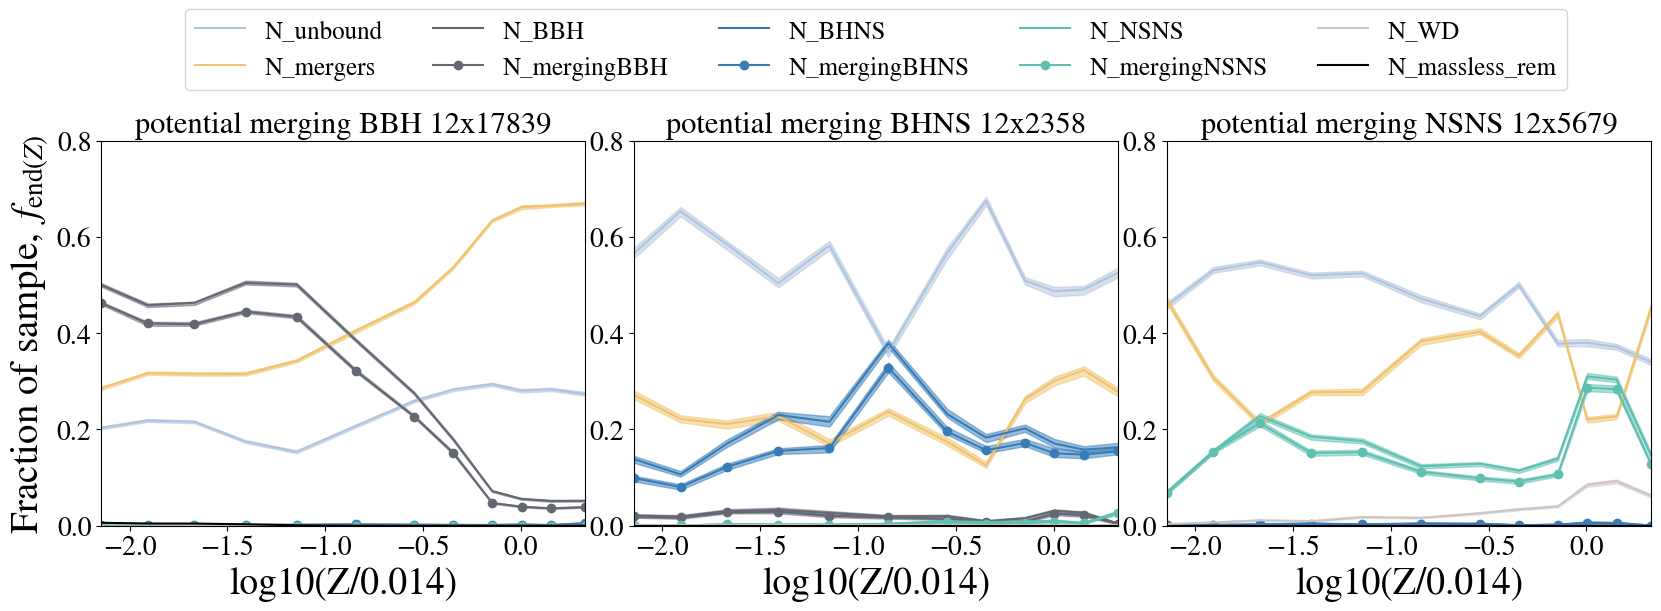

In [9]:
# Colors
color_dict = {'N_BBH': '#646873', 
              'N_mergingBBH': '#646873', 
              'N_BHNS': '#377CB7',
              'N_mergingBHNS': '#377CB7',
              'N_NSNS': '#5FC0B2',
              'N_mergingNSNS': '#5FC0B2',
              'N_WD': '#cfc6c2',
              'N_massless_rem': '#000000',
              'N_mergers': '#F0C26B', 
              'N_unbound': '#b0c4dd'}


###########################################
# Create a figure
fig = plt.figure(figsize=(20, 5))

# Create a GridSpec with 1 row and 3 columns
gs = GridSpec(1, 3, figure=fig)
axes = [fig.add_subplot(gs[0, i]) for i in range(3)] # Create 3 subplots on a line

# Loop over the axes and DCO flavors
for ax, flavor in zip(axes, ["BBH", "BHNS", "NSNS"]):
    # select your data
    DCO_flavor_number_dict = results_wbootstrap[flavor]

    # general info
    N_tot_DCO_prog = DCO_flavor_number_dict['N_tot_DCO_prog']
    metallicities   = DCO_flavor_number_dict['metallicities']

    # and the numbers in question
    for key in DCO_flavor_number_dict.keys():
        if key in ['metallicities', 'N_tot_DCO_prog']:
            continue
        # print(key)

        if 'merging' in key:
            MARKER = 'o'
        else:
            MARKER = ''
        
        # plot the median values
        ax.plot(np.log10(metallicities/0.014), DCO_flavor_number_dict[key]['median']/N_tot_DCO_prog, 
                color=color_dict[key], label= key, marker = MARKER)
        # and the +- 1 sigma ranges
        ax.fill_between(np.log10(metallicities/0.014), DCO_flavor_number_dict[key]['lower_bounds']/N_tot_DCO_prog, 
                        DCO_flavor_number_dict[key]['upper_bounds']/N_tot_DCO_prog, 
                        color=color_dict[key], alpha =0.5)

    # plot settings
    ax.set_title(f'potential merging {flavor} {len(metallicities)}x{N_tot_DCO_prog[0.0001]}', fontsize = 22)
    ax.set_xlim(np.log10(1e-4/0.014),np.log10(0.03/0.014))
    ax.set_xlabel('log10(Z/0.014)', fontsize = 27)
    ax.set_ylim(0,0.8)

axes[1].legend(bbox_to_anchor=(0.5, 1.1), loc='lower center', fontsize = 18, ncols = 5)

#########################
# plotvalues
fig.subplots_adjust(hspace=0.25, wspace=0.1)
axes[0].set_ylabel("Fraction of sample, $\, f_{\mathrm{end}(Z)}$", fontsize =28)

plt.savefig(f'../Figures/Extra_EndOfEvol_Bootstrapped_{sim_name}{channel_key}.pdf', bbox_inches='tight')
